<a href="https://colab.research.google.com/github/reinaldo-rosa-inpe/reinaldo-rosa-labac-inpe/blob/master/Copy_of_FisMat_Rubens_09_03_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte 1 - Experimento da função zeta

In [ ]:
from sympy import *
import mpmath
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [ ]:
s = symbols('s')
z = pi**(-s/2)*gamma(s/2)*zeta(s)
z

pi**(-s/2)*gamma(s/2)*zeta(s)

In [ ]:
z.subs(s,1/2+0.5j).evalf()

-1.97702795164031 + 5.49690501450151e-17*I

In [ ]:
D = simplify(z.diff(s)/z)
D

polygamma(0, s/2)/2 - log(pi)/2 + Derivative(zeta(s), s)/zeta(s)

In [ ]:
z_func = lambdify(s,z,modules=['mpmath'])
D_func = lambdify(s,D,modules=['mpmath', {'Derivative': lambda expr, z: mpmath.zeta(z,derivative=1)}])

In [ ]:
def argument_count(func,N, maxdegree=6):
  return 1/(2*mpmath.pi*1j)*mpmath.quad(func,[1.0+0.1j, 1+N*1j, N*1j, 0.1*1j,1+0.1*1j],maxdegree=maxdegree)

In [ ]:
expr = s**2 - s + 1/2
argument_count(lambdify(s,expr.diff(s)/expr), N=10)

mpc(real='1.0', imag='3.4287545414000525e-24')

In [ ]:
solve(expr)

[0.5 - 0.5*I, 0.5 + 0.5*I]

In [ ]:
def compute_points(z_func,N,npoints=10000,dps=15):
  old_dps = mpmath.mp.dps
  points = np.linspace(0,N, npoints)
  try:
    mpmath.mp.dps = dps
    L = [mpmath.chop(z_func(i)) for i in (1/2 + points*1j) ]
  finally:
    mpmath.mp.dps = old_dps
  if L[-1] == 0:
    warning.warn("Please, increase the precision")
  return L

def sign_changes(L):
  changes = 0
  assert im(L[0])==0, L[0]
  s = sign(L[0])
  for i in L[1:]:
    assert im(i)==0, i
    s_ = sign(i)
    if s_ == 0:
      continue
    if s_ != s:
      changes = changes + 1
    s = s_
  return changes

### N=20

In [ ]:
argument_count(D_func,20)

mpc(real='0.99999931531867581', imag='-3.2332902529067346e-24')

In [ ]:
sign_changes(lambdify(s,sin(s))(np.linspace(-10,10)))

7

In [ ]:
L = compute_points(z_func,20)
sign_changes(L)

1

### N = 25

In [ ]:
argument_count(D_func,25)

mpc(real='1.9961479945577916', imag='-3.2332902529067346e-24')

In [ ]:
L = compute_points(z_func,25)
sign_changes(L)

2

### N = 30

In [ ]:
argument_count(D_func,30)

mpc(real='2.9997317058520916', imag='-3.2332902529067346e-24')

In [ ]:
L = compute_points(z_func,30)
sign_changes(L)

3

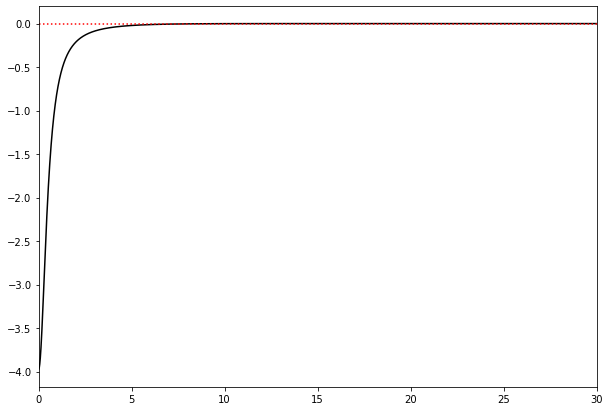

In [ ]:
def plotPointsBad(L,N):
  points = np.linspace(0,N,len(L))
  plt.figure(figsize=(10,7))
  plt.plot(points, L,color='k')
  plt.axhline(0.0, ls=':',color='r')
  plt.xlim(0,30)
plotPointsBad(L,30)

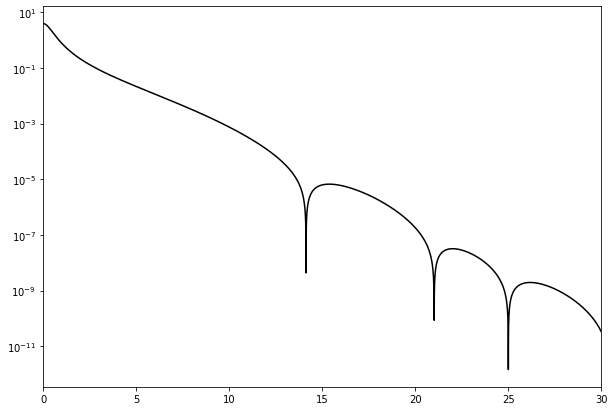

In [ ]:
def plotPointsBadLog(L,N):
  points = np.linspace(0,N,len(L))

  labs = [abs(i) for i in L]

  plt.figure(figsize=(10,7))
  plt.semilogy(points, labs,color='k')
  plt.xlim(0,N)
  #plt.axhline(0.0, ls=':',color='r')
  #plt.xlim(0,30)
plotPointsBadLog(L,30)

### N = 100

In [ ]:
print(argument_count(D_func,100))
print(argument_count(D_func,100,maxdegree=9))
L = compute_points(z_func,100,dps=50)
print(sign_changes(L))

(28.2480365368959 - 3.23329025290673e-24j)
(29.0000000059702 - 3.23329025290673e-24j)
29


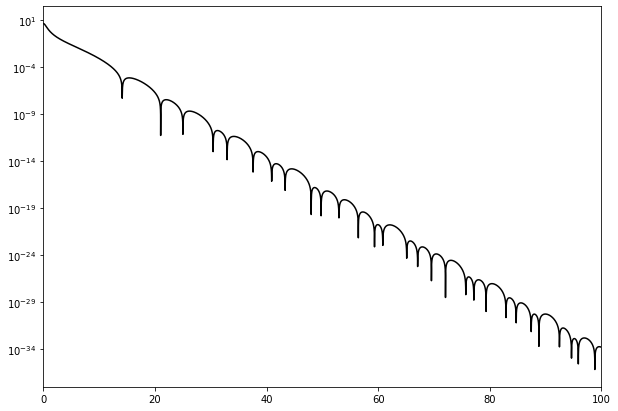

In [ ]:
plotPointsBadLog(L,100)

# Parte 2 - Função Ginzburg-Landau Complexa (CGL)

In [ ]:
import sympy
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
a, t, dx, b, c = sympy.symbols('A t x b c')
a = sympy.Function('A')(t,dx)
mA = sympy.Abs(a)
lap = a.diff(dx).diff(dx)
gl1D = sympy.lambdify((a,dx) , lap, modules=[sympy,np])
dadt = a+(1+sympy.I)*lap+(1+sympy.I)*a*(mA**2)
eq = sympy.Eq(a.diff(t), dadt)
eq

Eq(Derivative(A(t, x), t), (1 + I)*A(t, x)*Abs(A(t, x))**2 + A(t, x) + (1 + I)*Derivative(A(t, x), (x, 2)))

In [ ]:
def cgl1D(a,kwargs):
  c1,c2,delta_h = kwargs['c1'],kwargs['c2'],kwargs['delta_h']
  laplacian = (np.roll(a,-1)-2*a+np.roll(a,1))/(delta_h**2)
  return a +(1+1j*c1)*laplacian -(1+1j*c2)*(np.abs(a)**2)*a

def cgl2D(a,kwargs):
  c1,c2,delta_h = kwargs['c1'],kwargs['c2'],kwargs['delta_h']
  laplacian = (np.roll(a,-1,axis=0)-2*a+np.roll(a,1,axis=0))/(delta_h**2)
  laplacian += (np.roll(a,-1,axis=1)-2*a+np.roll(a,1,axis=1))/(delta_h**2)
  return a +(1+1j*c1)*laplacian -(1+1j*c2)*(np.abs(a)**2)*a 

def rk4Integration(a,fun,nit=1024,dt=1,**kwargs):
  snapshots = []
  timeStamp = a.copy()
  for it in range(nit):
    k1 = fun(a=timeStamp, kwargs=kwargs)
    k2 = fun(a=timeStamp+dt*k1/2, kwargs=kwargs)
    k3 = fun(a=timeStamp+dt*k2/2, kwargs=kwargs)
    k4 = fun(a=timeStamp+dt*k3, kwargs=kwargs)
    timeStamp = timeStamp+dt*(k1+2*k2+2*k3+k4)/6
    snapshots.append(timeStamp)
  return np.array(snapshots)

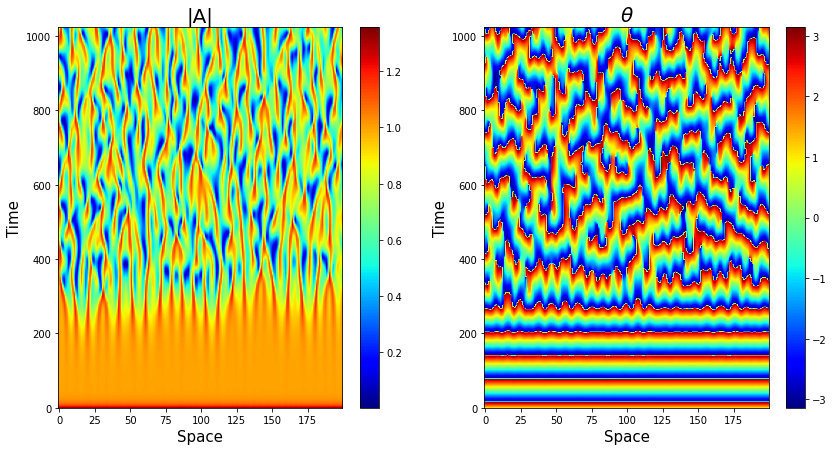

In [ ]:
# https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ss2017/numerische_Methoden_fuer_komplexe_Systeme_II/gle.pdf
# Defect turbulence example:

n = 200
noiseStrenght = 0.01

a0 = 1 + noiseStrenght*(np.random.rand(n)-0.5) + 1j*(1+noiseStrenght*(np.random.rand(n)-0.5))
#a0 = np.zeros(1024)
nit = int(1024)
dt = 0.05
delta_h = 1
c1,c2 = 2, -2
res = rk4Integration(a0,cgl1D,nit=nit,dt=dt,c1=c1,c2=c2,delta_h=delta_h)

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(np.abs(res),origin='lower',aspect='auto',cmap='jet')
plt.ylabel("Time",fontsize=15)
plt.xlabel("Space",fontsize=15)
plt.title("|A|",fontsize=20)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.angle(res),origin='lower',aspect='auto',cmap='jet')
plt.ylabel("Time",fontsize=15)
plt.xlabel("Space",fontsize=15)
plt.title(r"$\theta$",fontsize=20)
plt.colorbar()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in cosh
  


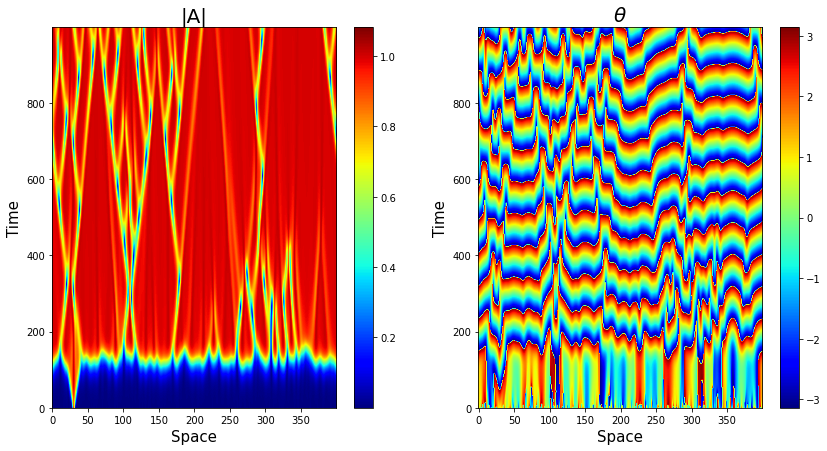

In [ ]:
# https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ss2017/numerische_Methoden_fuer_komplexe_Systeme_II/gle.pdf
# Intermittent example:

n = 400
noiseStrenght = 0.01

x = np.arange(n)
x = 1/np.cosh((x+10)**2)+0.8*1/np.cosh((x-30)**2)

a0 = x + noiseStrenght*(np.random.rand(n)-0.5) + 1j*(x+noiseStrenght*(np.random.rand(n)-0.5))
#a0 = np.zeros(1024)
nit = int(1000)
dt = 0.05
delta_h = 1
c1,c2 = 0.5, -1.5
res = rk4Integration(a0,cgl1D,nit=nit,dt=dt,c1=c1,c2=c2,delta_h=delta_h)

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(np.abs(res),origin='lower',aspect='auto',cmap='jet')
plt.ylabel("Time",fontsize=15)
plt.xlabel("Space",fontsize=15)
plt.title("|A|",fontsize=20)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.angle(res),origin='lower',aspect='auto',cmap='jet')
plt.ylabel("Time",fontsize=15)
plt.xlabel("Space",fontsize=15)
plt.title(r"$\theta$",fontsize=20)
plt.colorbar()
plt.show()

In [ ]:
# https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ss2017/numerische_Methoden_fuer_komplexe_Systeme_II/gle.pdf
# 2D example:

n = 200
noiseStrenght = 0.01

a0 = noiseStrenght*(np.random.rand(n,n)-0.5)

nit = int(1024)
dt = 0.05
delta_h = 1
c1,c2 = 0, 1.5
res = rk4Integration(a0,cgl2D,nit=nit,dt=dt,c1=c1,c2=c2,delta_h=delta_h)

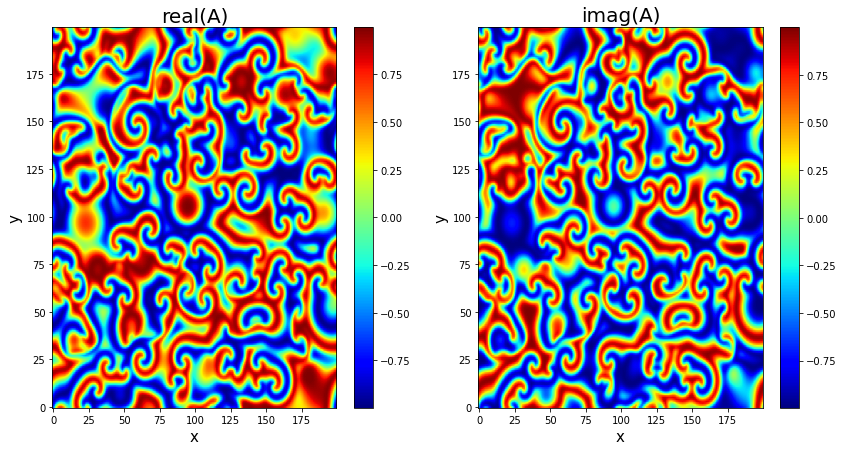

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(np.real(res[1023]),origin='lower',aspect='auto',cmap='jet')
plt.ylabel("y",fontsize=15)
plt.xlabel("x",fontsize=15)
plt.title("real(A)",fontsize=20)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.imag(res[1023]),origin='lower',aspect='auto',cmap='jet')
plt.ylabel("y",fontsize=15)
plt.xlabel("x",fontsize=15)
plt.title(r"imag(A)",fontsize=20)
plt.colorbar()
plt.show()

Excelente Trabalho Rubens!!!  Nota 10.  Conceito Final A+
